In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load data
df = pd.read_csv('dataset_fitness_tracker_2200.csv')

# Cek info awal
print("Info Data Awal:")
print(df.info())
df.head()

Info Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Activity        2090 non-null   object 
 1   Duration_min    2090 non-null   float64
 2   HeartRate_bpm   2090 non-null   float64
 3   Weight_kg       2090 non-null   float64
 4   Height_cm       2090 non-null   float64
 5   MET             2090 non-null   float64
 6   CaloriesBurned  2090 non-null   float64
dtypes: float64(6), object(1)
memory usage: 120.4+ KB
None


,Activity,Duration_min,HeartRate_bpm,Weight_kg,Height_cm,MET,CaloriesBurned
0,Yoga,47.607171,104.258344,68.511019,155.784299,2.5,127.995770
1,Workout,5.000000,107.287590,53.927424,181.851335,6.0,28.706763
2,Cycling,13.660889,146.552932,78.157215,175.485102,7.5,126.328352
3,Workout,38.502932,81.781749,73.327610,163.470126,6.0,267.877869
4,Workout,48.364132,NaN,89.114551,161.005567,6.0,410.624327


In [5]:
# 1. Hapus baris yang mengandung NaN (kosong)
df_clean = df.dropna().copy()
print(f"Jumlah data setelah dropna: {len(df_clean)}")

# 2. Hapus Outlier menggunakan IQR Method
numeric_cols = ['Duration_min', 'HeartRate_bpm', 'Weight_kg', 'Height_cm', 'MET']

print("\nMemproses Outlier...")
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data hanya ambil yang di dalam batas wajar
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Jumlah data bersih akhir: {len(df_clean)}")

Jumlah data setelah dropna: 1536

Memproses Outlier...
Jumlah data bersih akhir: 1513


In [6]:
# Reset index agar rapi
df_clean = df_clean.reset_index(drop=True)

# A. Normalisasi Data Numerik (Standard Scaling)
scaler = StandardScaler()
# Kita simpan parameter scaling ini ke dalam variabel 'scaler' untuk dipakai di App nanti
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# B. Encoding Data Kategori (Activity -> Angka)
df_processed = pd.get_dummies(df_clean, columns=['Activity'], drop_first=True)

# Cek hasil data yang sudah diproses
df_processed.head()

,Duration_min,HeartRate_bpm,Weight_kg,Height_cm,MET,CaloriesBurned,Activity_Running,Activity_Walking,Activity_Workout,Activity_Yoga
0,0.358811,-1.077197,0.305128,-0.909966,-1.225919,127.995770,False,False,False,True
1,-1.854155,-0.950000,-0.929787,1.738167,0.082791,28.706763,False,False,True,False
2,-1.404319,0.698745,1.121952,1.091426,0.643666,126.328352,False,False,False,False
3,-0.114053,-2.020985,0.712989,-0.129168,0.082791,267.877869,False,False,True,False
4,-0.142061,1.326332,0.801894,-0.006094,-0.852002,161.692154,False,True,False,False


In [7]:
# Pisahkan Fitur (X) dan Target (y)
X = df_processed.drop('CaloriesBurned', axis=1)
y = df_processed['CaloriesBurned']

# Simpan nama kolom (penting untuk App nanti agar urutannya sama)
model_columns = X.columns.tolist()

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Latih Model
print("Sedang melatih model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Selesai!")

Sedang melatih model...
Selesai!


Mean Absolute Error (MAE): 37.50
R-Squared Score: 0.78


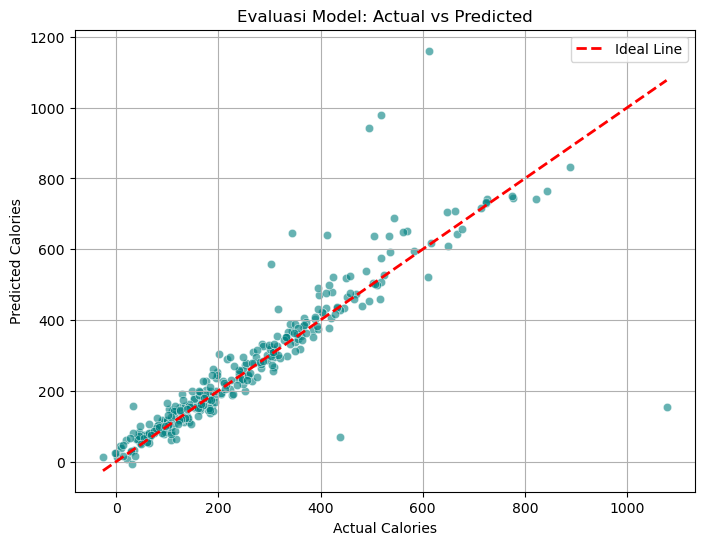

In [8]:
# Prediksi data test
y_pred = model.predict(X_test)

# Hitung Metrik
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared Score: {r2:.2f}")

# Visualisasi Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Evaluasi Model: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Simpan 3 komponen utama
joblib.dump(model, 'final_model.joblib')       # Modelnya
joblib.dump(scaler, 'final_scaler.joblib')     # Alat normalisasinya
joblib.dump(model_columns, 'final_columns.joblib') # Daftar nama kolomnya

print("File model berhasil disimpan! Siap lanjut ke tahap pembuatan App.")

File model berhasil disimpan! Siap lanjut ke tahap pembuatan App.
